In [1]:
import sys 
sys.path.append('../')

from pathlib import Path
import pandas as pd
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from utils.dataset import GraphDataset, data_split
from utils.transforms import GraphStandardScaler
from utils.models import GAT, GCN, Cheb, ChebGlobalPooling

root = Path('../EEGDataset/')
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

graph_data = GraphDataset(root, subjects, graph_type='corr_coef', reprocess=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

#### Visualize graph of random trial

In [2]:
from torch_geometric.data import Data

# Select a trial, load channel positions
sample = graph_data[54].clone()
edge_index = sample.edge_index
print(f'number of edges: {int(edge_index.shape[1]/2)}')
elec_coord_file = root/'electrode_coordinates.csv'
elec_coord = pd.read_csv(elec_coord_file, index_col=0)

labels = elec_coord.index.values
Xn = elec_coord['x'].values
Yn = elec_coord['y'].values
Zn = elec_coord['z'].values


Xe = []
Ye = []
Ze = []
for e in edge_index.T:
    Xe += [Xn[e[0]], Xn[e[1]], None]
    Ye += [Yn[e[0]], Yn[e[1]], None]
    Ze += [Zn[e[0]], Zn[e[1]], None]


import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=Xe, y=Ye, z=Ze,
    mode='lines',
    line=dict(color='rgb(0,0,0)', width=1),
    hoverinfo='none',
)

trace2 = go.Scatter3d(
    x=Xn, y=Yn, z=Zn,
    mode = 'markers',
    name = 'electrodes',
    marker = dict(
        symbol='circle',
        size=2,
        line=dict(color='rgb(50,50,50)',width=0.5),
    ),
    text=labels,
    hoverinfo='text',
)

axis=dict(
    showbackground=False,
    showline=False,
    showgrid=False,
    showticklabels=False,
    title='',
)

layout = go.Layout(
    scene = dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis),
    )
)

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
fig.show()

number of edges: 1625


In [3]:
def train(dataloader, model, loss_fn, optimizer, device='cpu', clip=None):
    model.train()

    tra_loss = 0
    for batch in dataloader:

        # compute prediction error
        pred = model(batch.to(device)).squeeze()
        loss = loss_fn(pred, batch.y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)   
        optimizer.step()

        tra_loss += loss.item() * len(batch)

    return tra_loss / len(dataloader.dataset)

def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):

            y = batch.y.to(device)
            pred = model(batch.to(device)).squeeze()
            val_loss += loss_fn(pred, y).item() * len(batch)
            correct += ((pred>0.5) == y).type(torch.float).sum().item()
    val_loss /= size
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct 


In [4]:
train_data, val_data, test_data = data_split(graph_data, [0.7, 0.1, 0.2])

# standardize values
scaler = GraphStandardScaler()
scaler.fit_transform(train_data)
scaler.transform(val_data)
scaler.transform(test_data)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

# Training parameters
lr = 0.001
epochs = 20

# model
model = Cheb(in_channels=151, hid_channels=32, K=3).to(device)

print('Number of parameters for model: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))
print(model.parameters)

# loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.1, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device))
    loss, _ = valid(val_loader, model, loss_fn, device=device)
    val_loss.append(loss)
    scheduler.step()
print('Done!')



Number of parameters for model:  18625
<bound method Module.parameters of Cheb(
  (conv1): ChebConv(151, 32, K=3, normalization=sym)
  (lin1): Linear(in_features=4096, out_features=1, bias=True)
  (sig): Sigmoid()
)>
Epoch 1
-------------------------------
Error: 
 Accuracy: 80.2%, Avg loss: 0.480604 

Epoch 2
-------------------------------
Error: 
 Accuracy: 75.7%, Avg loss: 0.523158 

Epoch 3
-------------------------------
Error: 
 Accuracy: 86.0%, Avg loss: 0.387024 

Epoch 4
-------------------------------
Error: 
 Accuracy: 82.0%, Avg loss: 0.390068 

Epoch 5
-------------------------------
Error: 
 Accuracy: 87.8%, Avg loss: 0.336913 

Epoch 6
-------------------------------
Error: 
 Accuracy: 82.0%, Avg loss: 0.384427 

Epoch 7
-------------------------------
Error: 
 Accuracy: 88.3%, Avg loss: 0.322443 

Epoch 8
-------------------------------
Error: 
 Accuracy: 88.3%, Avg loss: 0.331455 

Epoch 9
-------------------------------
Error: 
 Accuracy: 87.4%, Avg loss: 0.327706 



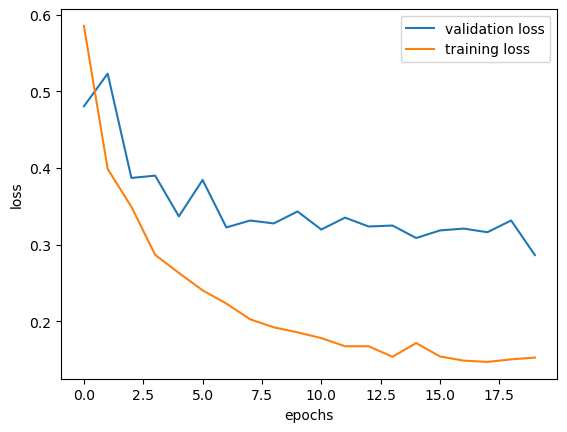

In [5]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['validation loss', 'training loss'])

In [6]:
print('Train ') 
valid(train_loader, model, loss_fn, device=device)

print('Validation ')
valid(val_loader, model, loss_fn, device=device)

print('Test ')
valid(test_loader, model, loss_fn, device=device)

Train 
Error: 
 Accuracy: 99.3%, Avg loss: 0.121726 

Validation 
Error: 
 Accuracy: 89.2%, Avg loss: 0.286367 

Test 
Error: 
 Accuracy: 85.9%, Avg loss: 0.328520 



(0.32851987903428187, 0.8587443946188341)

In [7]:
ksets = data_split(graph_data, [0.2]*5)    # 5-fold validation

scaler = GraphStandardScaler()

# hyper-parameters
models  = [GAT, GCN, Cheb]
lrs     = [0.001, 0.0001]
fov     = [1, 2, 3]                  # field of views
hid_chs = [16, 32]
epochs  = [20]

setups = []
for M in models:
    for lr in lrs:
        for f in fov:
            for chs in hid_chs:
                for e in epochs: 
                    parameters = {
                        'model':M,
                        'lr':lr,
                        'fov':int(f),
                        'chs':int(chs),
                        'epochs':int(e),
                        'val_loss':[],
                        'val_acc':[],
                    }
                    setups.append(parameters)

for i,s in enumerate(setups):
    for j in range(5):
        temp = [s.copy() for s in ksets]
        val_data = temp.pop(j)
        train_data = torch.utils.data.ConcatDataset(temp)
            
        # standardize values
        scaler.fit_transform(train_data)
        scaler.transform(val_data)

        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_data, batch_size=32)

        # model
        model = s['model'](151, s['chs'], s['fov']).to(device)

        # loss and optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.1, lr=s['lr'])

        print(f'Setup {i} - validation {j+1}')
        for e in range(epochs[-1]):
            train(train_loader, model, loss_fn, optimizer, device=device)

        print(f'Validation {j+1}')
        loss, accuracy = valid(val_loader, model, loss_fn, device=device)
        s['val_loss'].append(loss)
        s['val_acc'].append(accuracy)

# save results
with open('functionalGraphResults.pickle', 'wb') as handle:
    pickle.dump(setups, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setup 0 - validation 1
Validation 1
Error: 
 Accuracy: 87.0%, Avg loss: 0.354937 

Setup 0 - validation 2
Validation 2
Error: 
 Accuracy: 85.4%, Avg loss: 0.336974 

Setup 0 - validation 3
Validation 3
Error: 
 Accuracy: 83.8%, Avg loss: 0.377792 

Setup 0 - validation 4
Validation 4
Error: 
 Accuracy: 86.7%, Avg loss: 0.343020 

Setup 0 - validation 5
Validation 5
Error: 
 Accuracy: 84.7%, Avg loss: 0.366962 

Setup 1 - validation 1
Validation 1
Error: 
 Accuracy: 87.6%, Avg loss: 0.366940 

Setup 1 - validation 2
Validation 2
Error: 
 Accuracy: 84.0%, Avg loss: 0.346233 

Setup 1 - validation 3
Validation 3
Error: 
 Accuracy: 82.7%, Avg loss: 0.389891 

Setup 1 - validation 4
Validation 4
Error: 
 Accuracy: 84.7%, Avg loss: 0.345162 

Setup 1 - validation 5
Validation 5
Error: 
 Accuracy: 85.4%, Avg loss: 0.359681 

Setup 2 - validation 1
Validation 1
Error: 
 Accuracy: 79.3%, Avg loss: 0.470485 

Setup 2 - validation 2
Validation 2
Error: 
 Accuracy: 76.0%, Avg loss: 0.498862 

Setu

In [45]:
tra_loss1 = tra_loss 
val_loss1 = val_loss

In [29]:
tra_loss2 = tra_loss 
val_loss2 = val_loss 

In [46]:
import plotly.graph_objs as go
import numpy as np

x = np.arange(100)
trace1 = go.Scatter(x=x, y=tra_loss1, name='tra lin', line=dict(color='#EF553B'))
trace2 = go.Scatter(x=x, y=val_loss1, name='val lin', line=dict(color='#636EFA'))
trace3 = go.Scatter(x=x, y=tra_loss2, name='tra global', line=dict(color='#EF553B',dash='dot'))
trace4 = go.Scatter(x=x, y=val_loss2, name='val global', line=dict(color='#636EFA',dash='dot'))

layout=dict(
    title='Losses for linearization versus global pooling',
    xaxis_title='epochs',
    yaxis_title='binary cross entropy loss',
    )
fig = go.Figure([trace1,trace2,trace3,trace4], layout)
fig.show()
